# Trénovanie modelu na základe DST indexu, F10_indexu a BZ_GSM 24h dopredu 6 dozadu
Súbor: 6_24_pridane_atr.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.9 MB/s eta 0:00:0000:0100:01


### Kontrola kapacity servera

In [1]:
!nvidia-smi

Tue Mar 14 07:24:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   37C    P8     1W / 125W |    912MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [3]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'F10_INDEX',
            'BZ_GSM',
            'DST+24']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+24'
predicators = ['DST',
            'F10_INDEX',
            'BZ_GSM']

y_col='DST+24'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [4]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [5]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  753
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [6]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional((LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))(inputs)
c = LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-14 07:24:58.342486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [7]:
# callbacks
saved_model = "6_24_pridane_atr.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [8]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-03-14 07:25:12.242107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


753/753 [==============================] - ETA: 0s - loss: 325.5215 - mae: 11.4760
Epoch 1: val_mae improved from inf to 12.48509, saving model to 6_24_pridane_atr.hdf5
753/753 [==============================] - 52s 60ms/step - loss: 325.5215 - mae: 11.4760 - val_loss: 424.2910 - val_mae: 12.4851
Epoch 2/20
753/753 [==============================] - ETA: 0s - loss: 286.5108 - mae: 10.9582
Epoch 2: val_mae did not improve from 12.48509
753/753 [==============================] - 44s 59ms/step - loss: 286.5108 - mae: 10.9582 - val_loss: 409.5468 - val_mae: 12.5034
Epoch 3/20
753/753 [==============================] - ETA: 0s - loss: 278.7343 - mae: 10.8406
Epoch 3: val_mae did not improve from 12.48509
753/753 [==============================] - 45s 60ms/step - loss: 278.7343 - mae: 10.8406 - val_loss: 431.4175 - val_mae: 12.7490
Epoch 4/20
753/753 [==============================] - ETA: 0s - loss: 275.0088 - mae: 10.7727
Epoch 4: val_mae improved from 12.48509 to 12.37073, saving model to

In [9]:
# load best model24
model = keras.models.load_model('6_24_pridane_atr.hdf5')

In [10]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 10s 15ms/step


In [11]:
y_pred

array([[  3.7122037],
       [  4.615819 ],
       [  5.176755 ],
       ...,
       [-22.537006 ],
       [-23.47506  ],
       [-21.01166  ]], dtype=float32)

In [12]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[116068   8612]
 [ 13072  17501]]


In [13]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91    124680
           1       0.67      0.57      0.62     30573

    accuracy                           0.86    155253
   macro avg       0.78      0.75      0.77    155253
weighted avg       0.85      0.86      0.86    155253



In [14]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [15]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,-4.0,3.712204
7,2004-07-22 05:00:00,-2.0,4.615819
8,2004-07-22 06:00:00,-1.0,5.176755
9,2004-07-22 07:00:00,-2.0,4.549330
10,2004-07-22 08:00:00,0.0,4.300498
...,...,...,...
155254,2022-04-28 20:00:00,-19.0,-21.664772
155255,2022-04-28 21:00:00,-10.0,-22.632193
155256,2022-04-28 22:00:00,-4.0,-22.537006
155257,2022-04-28 23:00:00,-4.0,-23.475060


In [16]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.806458,-10.545719
std,16.336765,10.851276
min,-374.000000,-95.283333
25%,-16.000000,-16.375122
50%,-7.000000,-8.534825
75%,0.000000,-2.539426
max,77.000000,9.643931


<AxesSubplot: >

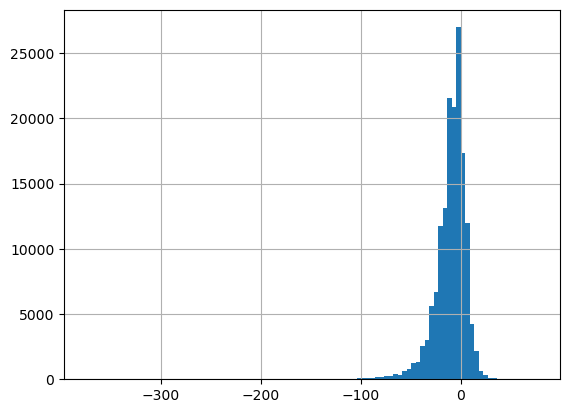

In [17]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

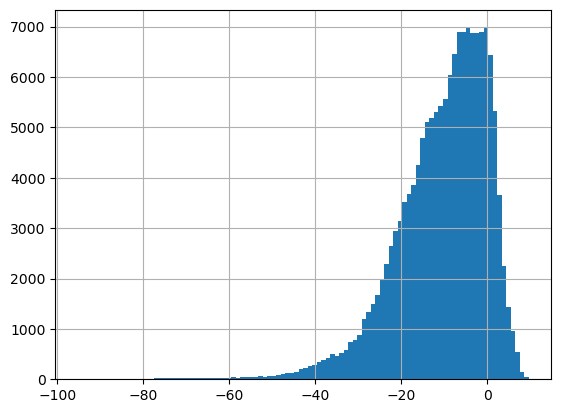

In [18]:
df["y_predict"].hist(bins=100)

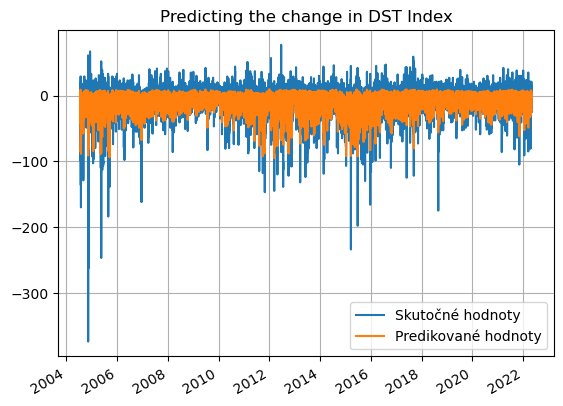

In [19]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [20]:
df.to_csv('predikcie_6_24_prid_atr.csv')

In [21]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[116068   8612]
 [ 13072  17501]]


In [22]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)

116068
8612
13072
17501


In [23]:
from sklearn.metrics import *
TN = cm[0,0] 
print("TN={}".format(TN))
FP = cm[0,1]
print("FP={}".format(FP))
FN = cm[1,0] 
print("FN={}".format(FN))
TP = cm[1,1] 
print("TP={}".format(TP))
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
fpr, tpr, threshold = roc_curve(y_test2, y_pred2)
AUC = auc(fpr, tpr)
print("AUC={}".format(AUC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

TN=116068
FP=8612
FN=13072
TP=17501
TPR=0.5724331926863573
TNR=0.9309271735643246
PPV=0.6702025810898786
NPV=0.8987765216044603
FPR=0.06907282643567533
FNR=0.42756680731364277
FDR=0.3297974189101214
ACC=0.860331201329443
AUC=0.751680183125341
MCC=0.5351649554307595
